### ***Importing Libraries***

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

### ***RAVDESS Dataframe***

*Here is the filename identifiers as per the official RAVDESS website:*

* *Modality (01 = full-AV, 02 = video-only, 03 = audio-only).*
* *Vocal channel (01 = speech, 02 = song).*
* *Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).*
* *Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.*
* *Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").*
* *Repetition (01 = 1st repetition, 02 = 2nd repetition).*
* *Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).*

*So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4. This means the meta data for the audio file is:*

* *Video-only (02)*
* *Speech (01)*
* *Fearful (06)*
* *Normal intensity (01)*
* *Statement "dogs" (02)*
* *1st Repetition (01)*
* *12th Actor (12) - Female (as the actor ID number is even)*

In [2]:
# Paths for data.

Ravdess = "audio_speech_actors_01-24/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
file_gender = []

for dir in ravdess_directory_list:
  actor = os.listdir(Ravdess + dir)
  # extracting files for each actor

  for file in actor:
    part = file.split('.')[0]
    part = part.split('-')

    # third part in each file represents the emotion associated with that file
    # last part represents the actor number (where even number represents female and vice-versa)

    file_emotion.append(int(part[2])) 
    file_gender.append(int(part[-1]))
    file_path.append(Ravdess + dir +'/'+ file)

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])

# Dataframe for the gender of actors
gender_df = pd.DataFrame(file_gender, columns=['Gender'])

# Dataframe for emotion of files
path_df = pd.DataFrame(file_path, columns=['Path'])

Ravdess_df = pd.concat([emotion_df, gender_df, path_df], axis=1)

# Changing integers to actual emotions and 'male'/'female'
Ravdess_df.Emotion.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}, inplace=True)

for i in Ravdess_df.Gender:
  if i % 2 == 0:
    Ravdess_df.Gender.replace({i:'female'}, inplace=True)
  else:
    Ravdess_df.Gender.replace({i:'male'}, inplace=True)

Ravdess_df.head(150)

,Emotion,Gender,Path
0,neutral,male,audio_speech_actors_01-24/Actor_01/03-01-01-01...
1,neutral,male,audio_speech_actors_01-24/Actor_01/03-01-01-01...
2,neutral,male,audio_speech_actors_01-24/Actor_01/03-01-01-01...
3,neutral,male,audio_speech_actors_01-24/Actor_01/03-01-01-01...
4,calm,male,audio_speech_actors_01-24/Actor_01/03-01-02-01...
...,...,...,...
145,sad,male,audio_speech_actors_01-24/Actor_03/03-01-04-02...
146,sad,male,audio_speech_actors_01-24/Actor_03/03-01-04-02...
147,sad,male,audio_speech_actors_01-24/Actor_03/03-01-04-02...
148,angry,male,audio_speech_actors_01-24/Actor_03/03-01-05-01...


In [4]:
Ravdess_df.to_csv("Ravdess_df.csv", index=False)
Ravdess_df.tail(100)

,Emotion,Gender,Path
1340,sad,male,audio_speech_actors_01-24/Actor_23/03-01-04-01...
1341,sad,male,audio_speech_actors_01-24/Actor_23/03-01-04-01...
1342,sad,male,audio_speech_actors_01-24/Actor_23/03-01-04-01...
1343,sad,male,audio_speech_actors_01-24/Actor_23/03-01-04-01...
1344,sad,male,audio_speech_actors_01-24/Actor_23/03-01-04-02...
...,...,...,...
1435,surprised,female,audio_speech_actors_01-24/Actor_24/03-01-08-01...
1436,surprised,female,audio_speech_actors_01-24/Actor_24/03-01-08-02...
1437,surprised,female,audio_speech_actors_01-24/Actor_24/03-01-08-02...
1438,surprised,female,audio_speech_actors_01-24/Actor_24/03-01-08-02...


## ***Data Augmentation***
* *Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.*
* *To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.*
* *The objective is to make our model invariant to those perturbations and enhace its ability to generalize.*
* *In order to this to work adding the perturbations must conserve the same label as the original training sample.*

* *In images data augmention can be performed by shifting the image, zooming, rotating ...*

In [5]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

## ***Feature Extraction***
 *Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.*

In [6]:
def extract_features(data):
    result = np.array([])

    # Chroma_stft
    stft = np.abs(librosa.stft(data, n_fft=2048))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) 

    '''# Spectral Centroid
    speCen = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, speCen))

    # Spectral Contrast
    specCont = np.mean(librosa.feature.spectral_contrast(data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, specCont))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))        # stacking horizontally
    '''
    
    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [7]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [8]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,labels
0,0.706492,0.756853,0.735217,0.731014,0.715156,0.667529,0.673754,0.722173,0.748969,0.739946,...,-2.579286,-3.758422,-2.279910,-4.431667,-1.909897,-1.563621,-2.195246,-4.739533,-1.921986,neutral
1,0.733336,0.771764,0.759095,0.761226,0.776600,0.693059,0.666140,0.710681,0.738042,0.743363,...,-3.020877,-2.569619,-2.592328,-3.904442,-2.363496,-1.395479,-2.266245,-4.031845,-2.193072,neutral
2,0.640605,0.712837,0.743736,0.714797,0.701402,0.694569,0.663853,0.688527,0.742508,0.746258,...,-1.507560,-3.217639,-1.749398,-3.614774,0.404047,-1.949812,-3.587139,-2.929828,-3.275923,neutral
3,0.674966,0.723259,0.724594,0.681301,0.670643,0.674574,0.630036,0.680146,0.708276,0.735747,...,-3.439861,-3.159783,-3.162004,-4.308258,-0.944997,-1.886518,-3.991654,-4.416666,-2.964069,neutral
4,0.790736,0.828314,0.812467,0.786452,0.792344,0.730642,0.658394,0.715449,0.749436,0.772629,...,-2.090105,-2.391069,-2.673430,-2.601240,-0.953242,-1.463220,-2.951656,-3.304408,-2.608819,neutral


In [9]:
Features.describe()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000
mean,0.629418,0.632434,0.637029,0.643363,0.629631,0.606899,0.601365,0.620671,0.637755,0.638614,...,-0.041649,2.284048,0.303373,2.473491,0.371636,2.129671,-0.298381,1.120716,-0.486260,1.435298
std,0.087857,0.097878,0.100453,0.102935,0.106582,0.092052,0.078524,0.080982,0.079603,0.076857,...,3.495546,3.847941,3.567674,3.784146,3.351219,3.128461,2.987511,2.981060,2.748151,2.714747
min,0.333036,0.304863,0.289903,0.275471,0.266618,0.284001,0.262918,0.245542,0.267086,0.340798,...,-12.086599,-6.370630,-8.969918,-5.932217,-10.705795,-5.919671,-10.509711,-6.863749,-8.568091,-5.991527
25%,0.570085,0.565688,0.567421,0.572942,0.558007,0.550929,0.555510,0.569920,0.587488,0.589822,...,-2.301038,-0.513996,-1.995916,-0.292371,-1.803162,-0.037147,-2.166223,-0.891784,-2.334804,-0.471214
50%,0.635169,0.638796,0.643914,0.649820,0.635935,0.615567,0.609214,0.627350,0.644191,0.645207,...,-0.389828,1.629721,-0.163444,1.808518,-0.010511,1.712110,-0.433493,0.836794,-0.628156,1.167405
75%,0.693455,0.704341,0.710202,0.718896,0.705332,0.671198,0.657009,0.678287,0.694592,0.693502,...,2.024151,4.402545,2.274121,4.693936,2.201158,3.886571,1.319209,2.812202,1.103852,3.086075
max,0.865830,0.881299,0.896561,0.903850,0.913389,0.885736,0.854075,0.842388,0.853374,0.836283,...,22.403570,22.198193,18.186296,18.379742,14.031037,17.308300,12.772933,17.463522,13.956020,15.627288


## ***Data Preparation***

In [10]:
"""Import the required modules"""

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd

In [11]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [12]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [13]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1, shuffle=True, test_size=0.25)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 52), (3240, 8), (1080, 52), (1080, 8))

In [14]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 52), (3240, 8), (1080, 52), (1080, 8))

In [23]:
print('Train dimension:')
print(x_train.shape)
print('Test dimension:')
print(x_test.shape)

print('Train labels dimension:')
print(y_train.shape)
print('Test labels dimension:')
print(y_test.shape)

Train dimension:
(3240, 52, 1)
Test dimension:
(1080, 52, 1)
Train labels dimension:
(3240, 8)
Test labels dimension:
(1080, 8)


In [15]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

## ***Modelling***

In [17]:
# LSTM Classifier
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *

In [28]:
model = Sequential()
model.add(BatchNormalization(axis=-1, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(128,dropout=0.1, recurrent_dropout=0.2, return_sequences=True))
'''
model.add(Dense(64))
model.add(Dropout(0.4))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Dropout(0.4))
model.add(Activation('relu'))
'''
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(16, dropout=0.1, recurrent_dropout=0.2, return_sequences=False))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

# Configures the model for training
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 52, 1)             4         
_________________________________________________________________
lstm_14 (LSTM)               (None, 52, 128)           66560     
_________________________________________________________________
lstm_15 (LSTM)               (None, 52, 64)            49408     
_________________________________________________________________
lstm_16 (LSTM)               (None, 16)                5184      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                

In [29]:
# Training the model
history=model.fit(x_train, y_train, batch_size=32, epochs=200, validation_data=(x_test, y_test))

Epoch 1/200
102/102 [==============================] - 30s 294ms/step - loss: 2.0210 - accuracy: 0.1880 - val_loss: 1.9826 - val_accuracy: 0.2019
Epoch 2/200
102/102 [==============================] - 26s 255ms/step - loss: 1.8994 - accuracy: 0.2778 - val_loss: 1.8660 - val_accuracy: 0.3130
Epoch 3/200
102/102 [==============================] - 27s 261ms/step - loss: 1.8423 - accuracy: 0.2923 - val_loss: 1.8384 - val_accuracy: 0.3102
Epoch 4/200
102/102 [==============================] - 26s 257ms/step - loss: 1.8003 - accuracy: 0.3182 - val_loss: 1.8299 - val_accuracy: 0.3046
Epoch 5/200
102/102 [==============================] - 26s 253ms/step - loss: 1.7723 - accuracy: 0.3293 - val_loss: 1.7944 - val_accuracy: 0.3231
Epoch 6/200
102/102 [==============================] - 20s 196ms/step - loss: 1.7546 - accuracy: 0.3299 - val_loss: 1.7649 - val_accuracy: 0.3259
Epoch 7/200
102/102 [==============================] - 22s 211ms/step - loss: 1.7326 - accuracy: 0.3444 - val_loss: 1.7543 -

34/34 [==============================] - 1s 25ms/step - loss: 1.3064 - accuracy: 0.6296
Accuracy of our model on test data :  62.962961196899414 %


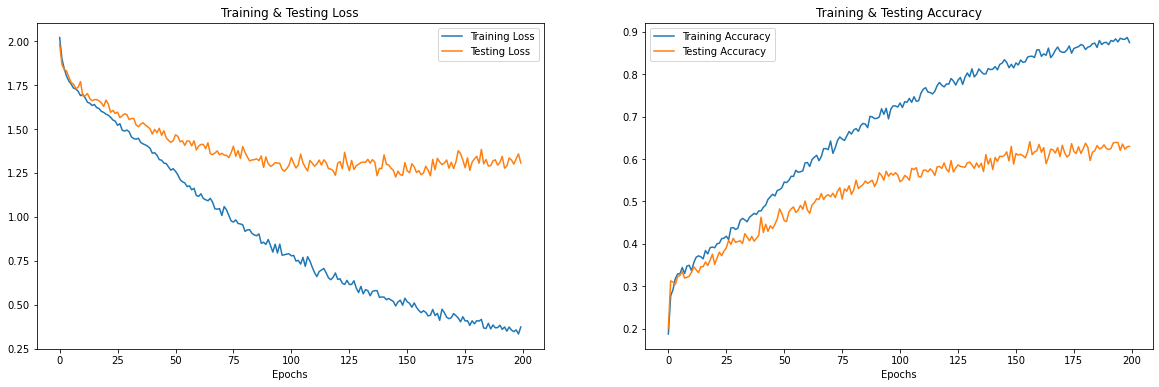

In [30]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [31]:
# predicting on test data.

pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [32]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(50)

,Predicted Labels,Actual Labels
0,disgust,happy
1,fearful,fearful
2,disgust,surprised
3,surprised,surprised
4,happy,happy
5,disgust,disgust
6,fearful,disgust
7,surprised,sad
8,calm,calm
9,neutral,sad


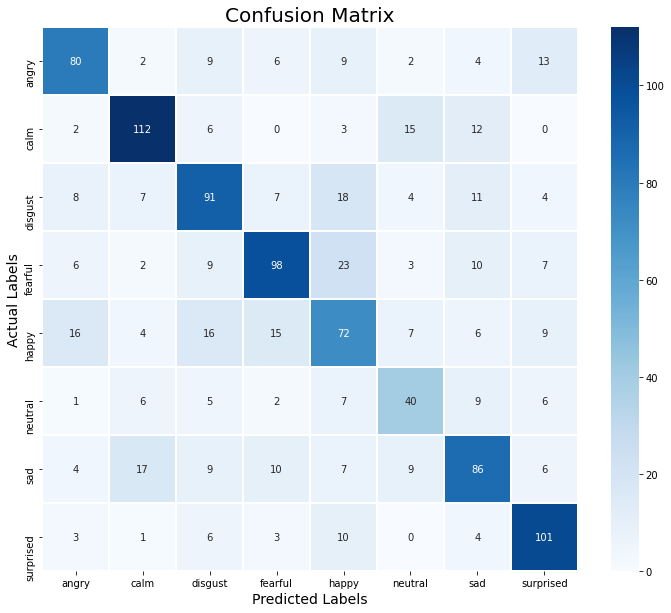

In [33]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.67      0.64      0.65       125
        calm       0.74      0.75      0.74       150
     disgust       0.60      0.61      0.60       150
     fearful       0.70      0.62      0.66       158
       happy       0.48      0.50      0.49       145
     neutral       0.50      0.53      0.51        76
         sad       0.61      0.58      0.59       148
   surprised       0.69      0.79      0.74       128

    accuracy                           0.63      1080
   macro avg       0.62      0.63      0.62      1080
weighted avg       0.63      0.63      0.63      1080

